# 🟢 **3. Early Fusion**🟢

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd


# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


# **3. Fusión de modelos: Early Fusion**

Combinaré los datos en una unica entrada desde el inicio para que el modelo capture lreaciones de imagenes con datos tabulares e ir optimizando en conjunto. Ene ste punto tenemos data tabular e imagenes lista apra poder hacer el Early-Fusion.

Las imagenes pasan por un modelo re-entrenado, en este caso Resnet50 y se convierten en un vector comprimido de features de las imágenes.

Los datos de procesan por capas densas y generan otroa vector de Features.

Estos se concatenan y se pasan a una serie de capas densas que realizan la predicción final.

Luego se evalua funciones de perdida y optimizacion.

## **Cargar tabulares e imágenes** 🏠 📃

**Variables:**

X_train, X_val, X_test: son los datos input del modelo, las Features que utilizaré para hacer las predicciones.

Como son datos de dos tipos, tabulares e imágenes, las viarables quedarian asi:

**Inputs:**

Imágenes: X_train_imgs, X_train_imgs, X_test_imgs
Tabulares: X_train_tab, X_val_tab, X_test_tab


**Output:**
Y_train, Y_val, Y_test

In [ ]:
# Ruta base
base_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/"

# Cargar imágenes normalizadas para ResNet50
imgs_train = np.load(base_path + "imgs_train_resnet.npy")
imgs_val = np.load(base_path + "imgs_val_resnet.npy")
imgs_test = np.load(base_path + "imgs_test_resnet.npy")

# Cargar datos tabulares actualizados
X_train = pd.read_csv(base_path + "X_train_tab.csv", sep=';')
X_val = pd.read_csv(base_path + "X_val_tab.csv", sep=';')
X_test = pd.read_csv(base_path + "X_test_tab.csv", sep=';')

# Cargar etiquetas (log)
y_train = np.load(base_path + "y_train_tab.npy")
y_val = np.load(base_path + "y_val_tab.npy")
y_test = np.load(base_path + "y_test_tab.npy")

# Verificar formas de los datos
print(f"Shape de imgs_train: {imgs_train.shape}")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")


Shape de imgs_train: (2110, 224, 224, 3)
Shape de X_train: (2110, 32)
Shape de y_train: (2110,)


# **Verificación normalización de datos tabulares**

In [ ]:
# Verificar estadísticas de los datos tabulares
import numpy as np

print("Estadísticas de X_train:")
print(f"Min: {X_train.min()}, Max: {X_train.max()}, Mean: {X_train.mean()}, Std: {X_train.std()}\n")

print("Estadísticas de X_val:")
print(f"Min: {X_val.min()}, Max: {X_val.max()}, Mean: {X_val.mean()}, Std: {X_val.std()}\n")

print("Estadísticas de X_test:")
print(f"Min: {X_test.min()}, Max: {X_test.max()}, Mean: {X_test.mean()}, Std: {X_test.std()}\n")


Estadísticas de X_train:
Min: host_response_time                0.000000
host_response_rate                0.000000
host_acceptance_rate              0.000000
host_is_superhost                 0.000000
host_total_listings_count         0.693147
host_has_profile_pic              0.000000
host_identity_verified            0.000000
neighbourhood_cleansed            0.000000
latitude                         -3.575181
longitude                        -2.775613
accommodates                      0.010000
bathrooms                         0.010000
bedrooms                          0.010000
beds                              0.010000
minimum_nights                    0.693147
maximum_nights                    1.386294
availability_365                  0.000000
review_scores_cleanliness         0.000000
review_scores_checkin             0.000000
review_scores_communication       0.000000
review_scores_location            0.000000
instant_bookable                  0.000000
reviews_per_month       

# **Configuración Early-Fusion**

Implementaré la arquitectura de Early Fusion combinando las features extraídas de ResNet50 con los datos tabulares.

✅Configurar el modelo base de ResNet50 sin la capa de clasificación para extraer un vector de características de las imágenes.

✅Crear la arquitectura de Early Fusion combinando el vector de features extraídas con las variables tabulares.

✅Definir la red neuronal que tomará como entrada el vector fusionado (imágenes + tabular) y realizará la predicción.

✅Implementar la fase de entrenamiento del modelo de Early Fusion y ya está corriendo.

### **Utilizaré los Hiperparametros que se alncanzaron a encontrar en la optimización que fue interrumpida en el modelado de ResNet50**

✔ Descongelación de las últimas 20 capas de ResNet50 para mejorar el aprendizaje.

✔ Capas densas optimizadas con 384 y 256 neuronas según la optimización.

✔ Dropout de 0.2 para regularización.

✔ Learning rate óptimo (0.00058264).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Definir la entrada de imágenes
img_input = layers.Input(shape=(224, 224, 3))

# Definir el modelo base ResNet50 sin la capa de clasificación final
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=img_input)
base_model.trainable = False  # Transfer Learning inicial

# Extraer características con Global Average Pooling
img_features = layers.GlobalAveragePooling2D()(base_model.output)

# Definir entrada para los datos tabulares
tabular_input = layers.Input(shape=(X_train.shape[1],))

# Concatenar features de imágenes y datos tabulares
merged = layers.Concatenate()([img_features, tabular_input])

# Definir la red densa después de la concatenación
x = layers.Dense(384, activation="relu")(merged)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)

# Definir el modelo completo con dos entradas
model = Model(inputs=[img_input, tabular_input], outputs=output)

# Compilar el modelo con el mejor learning rate encontrado
model.compile(optimizer=optimizers.Adam(learning_rate=0.00058264),  # Valor encontrado en tuning
              loss="mse",
              metrics=["mae"])

# Mostrar resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,520,961 (93.54 MB)

 Trainable params: 931,969 (3.56 MB)

 Non-trainable params: 23,588,992 (89.98 MB)

# **Entrenamiento Early-Fusion**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir callbacks para evitar sobreajuste
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet.keras", save_best_only=True)
]

# Entrenar el modelo con imágenes y datos tabulares
history = model.fit(
    [imgs_train, X_train], y_train,
    validation_data=([imgs_val, X_val], y_val),
    epochs=7,  # Reducción de epochs basada en tuning
    batch_size=32,  # Mejor batch size encontrado
    callbacks=callbacks,
    verbose=1
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet.keras")

print("Modelo de Early Fusion guardado correctamente.")


Epoch 1/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 533s 8s/step - loss: 9.4917 - mae: 2.5974 - val_loss: 3.5725 - val_mae: 1.7037
Epoch 2/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 534s 7s/step - loss: 0.8778 - mae: 0.7540 - val_loss: 1.5154 - val_mae: 1.0136
Epoch 3/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 508s 8s/step - loss: 0.6326 - mae: 0.6258 - val_loss: 1.0157 - val_mae: 0.7993
Epoch 4/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 507s 8s/step - loss: 0.5684 - mae: 0.5826 - val_loss: 0.7843 - val_mae: 0.6914
Epoch 5/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 544s 7s/step - loss: 0.4340 - mae: 0.5195 - val_loss: 0.5832 - val_mae: 0.5775
Epoch 6/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 503s 7s/step - loss: 0.3922 - mae: 0.4934 - val_loss: 0.5577 - val_mae: 0.5697
Epoch 7/7
66/66 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - loss: 0.4135 - mae: 0.4995 - val_loss: 0.5622 - val_mae: 0.5661
Modelo de Early Fusion guardado correctamente.


# **Evaluación métricas Early-Fusion**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predicciones en log
y_pred_train_log = model.predict([imgs_train, X_train])
y_pred_val_log = model.predict([imgs_val, X_val])
y_pred_test_log = model.predict([imgs_test, X_test])

# Convertir predicciones y etiquetas a escala original (exponencial)
y_pred_train_real = np.exp(y_pred_train_log)
y_pred_val_real = np.exp(y_pred_val_log)
y_pred_test_real = np.exp(y_pred_test_log)

y_train_real = np.exp(y_train)
y_val_real = np.exp(y_val)
y_test_real = np.exp(y_test)

# calcular métricas
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Evaluación en Log
mae_train_log, rmse_train_log, r2_train_log = calcular_metricas(y_train, y_pred_train_log)
mae_val_log, rmse_val_log, r2_val_log = calcular_metricas(y_val, y_pred_val_log)
mae_test_log, rmse_test_log, r2_test_log = calcular_metricas(y_test, y_pred_test_log)

# Evaluación en Escala Original
mae_train_real, rmse_train_real, r2_train_real = calcular_metricas(y_train_real, y_pred_train_real)
mae_val_real, rmse_val_real, r2_val_real = calcular_metricas(y_val_real, y_pred_val_real)
mae_test_real, rmse_test_real, r2_test_real = calcular_metricas(y_test_real, y_pred_test_real)

# Mostrar Resultados
print("\nResultados en Log:")
print(f"Entrenamiento (Log): MAE: {mae_train_log:.4f}, RMSE: {rmse_train_log:.4f}, R²: {r2_train_log:.4f}")
print(f"Validación (Log): MAE: {mae_val_log:.4f}, RMSE: {rmse_val_log:.4f}, R²: {r2_val_log:.4f}")
print(f"Test (Log): MAE: {mae_test_log:.4f}, RMSE: {rmse_test_log:.4f}, R²: {r2_test_log:.4f}")

print("\nResultados en Escala Original:")
print(f"Entrenamiento (Original): MAE: {mae_train_real:.4f}, RMSE: {rmse_train_real:.4f}, R²: {r2_train_real:.4f}")
print(f"Validación (Original): MAE: {mae_val_real:.4f}, RMSE: {rmse_val_real:.4f}, R²: {r2_val_real:.4f}")
print(f"Test (Original): MAE: {mae_test_real:.4f}, RMSE: {rmse_test_real:.4f}, R²: {r2_test_real:.4f}")

print("Evaluación completada.")


66/66 ━━━━━━━━━━━━━━━━━━━━ 414s 6s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step

Resultados en Log:
Entrenamiento (Log): MAE: 0.4055, RMSE: 0.5179, R²: 0.4834
Validación (Log): MAE: 0.5697, RMSE: 0.7468, R²: -0.0459
Test (Log): MAE: 0.5574, RMSE: 0.7112, R²: -0.0576

Resultados en Escala Original:
Entrenamiento (Original): MAE: 72.6434, RMSE: 135.2558, R²: 0.4848
Validación (Original): MAE: 95.3863, RMSE: 184.7181, R²: -0.0071
Test (Original): MAE: 92.3890, RMSE: 158.9071, R²: 0.0455
Evaluación completada.


## 👀 **Análisis resultados Early Fusion:**

Entrenamiento: R² positivo tanto en log como en escala original, indicando que el modelo está aprendiendo.

Validación y Test: El R² sigue siendo bajo, pero mejor que los modelos anteriores.

Diferencia entre entrenamiento y validación: El modelo podría estar capturando más patrones en los datos de entrenamiento, pero aún no generaliza bien.

## **Visualizaciones de las métricas y plots de predicciones Early Fusion**


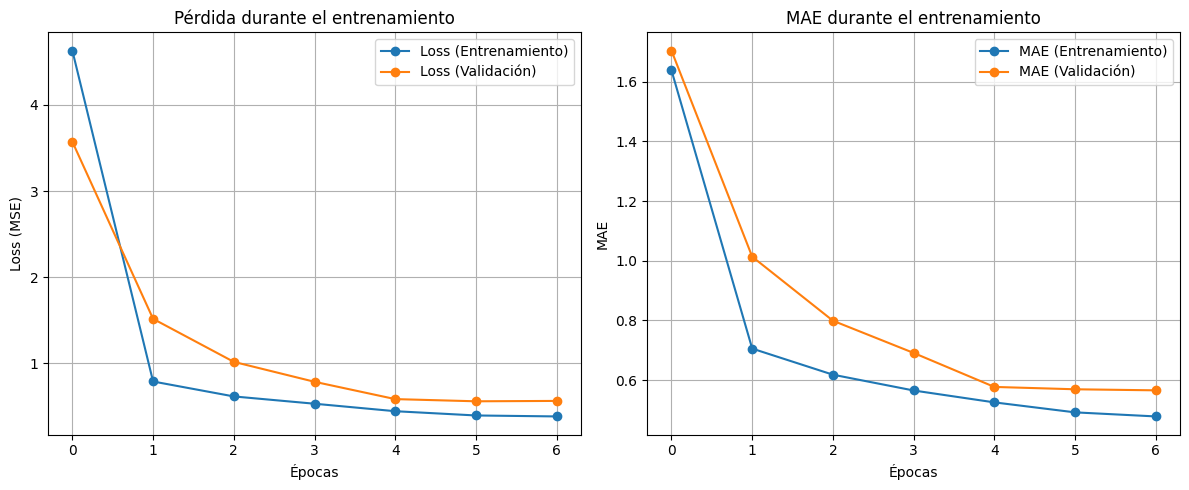

In [ ]:
import matplotlib.pyplot as plt

# Verificar si el historial tiene las métricas necesarias
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(12, 5))

    # Pérdida durante las épocas
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Loss (Entrenamiento)", marker="o")
    plt.plot(history.history["val_loss"], label="Loss (Validación)", marker="o")
    plt.xlabel("Épocas")
    plt.ylabel("Loss (MSE)")
    plt.title("Pérdida durante el entrenamiento")
    plt.legend()
    plt.grid()

    # MAE durante las épocas
    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="MAE (Entrenamiento)", marker="o")
    plt.plot(history.history["val_mae"], label="MAE (Validación)", marker="o")
    plt.xlabel("Épocas")
    plt.ylabel("MAE")
    plt.title("MAE durante el entrenamiento")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron métricas de pérdida en el historial.")


### **Pérdida y MAE durante el entrenamiento Early-Fusion**

Tanto en entrenamiento como en validación disminuyen constantemente, lo que sugiere que el modelo está aprendiendo.

Sin embargo, la validación muestra una diferencia con respecto al entrenamiento en las últimas épocas. Esto puede indicar un posible inicio de sobreajuste si la tendencia continúa en más épocas.

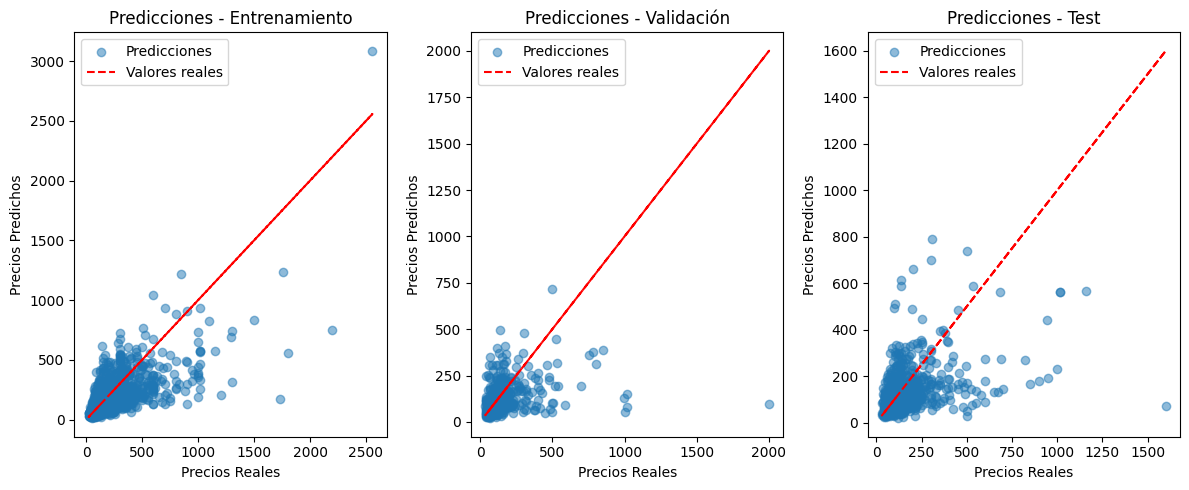

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario de métricas
metricas_log = {
    "MAE": [mae_train_log, mae_val_log, mae_test_log],
    "RMSE": [rmse_train_log, rmse_val_log, rmse_test_log],
    "R²": [r2_train_log, r2_val_log, r2_test_log]
}

metricas_real = {
    "MAE": [mae_train_real, mae_val_real, mae_test_real],
    "RMSE": [rmse_train_real, rmse_val_real, rmse_test_real],
    "R²": [r2_train_real, r2_val_real, r2_test_real]
}

etiquetas = ["Entrenamiento", "Validación", "Test"]


# Scatter plot de predicciones vs valores reales en escala original
plt.figure(figsize=(12, 5))

# Entrenamiento
plt.subplot(1, 3, 1)
plt.scatter(y_train_real, y_pred_train_real, alpha=0.5, label="Predicciones")
plt.plot(y_train_real, y_train_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Entrenamiento")
plt.legend()

# Validación
plt.subplot(1, 3, 2)
plt.scatter(y_val_real, y_pred_val_real, alpha=0.5, label="Predicciones")
plt.plot(y_val_real, y_val_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Validación")
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.scatter(y_test_real, y_pred_test_real, alpha=0.5, label="Predicciones")
plt.plot(y_test_real, y_test_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Test")
plt.legend()

plt.tight_layout()
plt.show()


### **Dispersión de predicciones vs valores reales Early Fusion**

Entrenamiento:

Hay una alineación aceptable con la diagonal roja, aunque hay varios puntos dispersos que indican errores en la predicción.

Validación y Test:

Existe mucha dispersión de valores predichos lejos de la línea roja, lo que indica que el modelo tiene dificultades para generalizar.

Predicciones más bajas que los valores reales, el modelo subestima los precios.

La falta de alineación sugiere que el modelo aún no ha capturado correctamente la relación entre las variables tabulares, imágenes y el precio.


### **Mejoraré la generalización**

✅ Desbloqueo de las últimas 30 capas de ResNet50 para mejor ajuste.

✅ Cambio de optimizador de Adam a AdamW con weight decay para evitar sobreajuste.

✅ Cambio de función de pérdida de MSE a Huber Loss para mitigar valores extremos.

✅ Añadida una capa convolucional 1x1 antes de la extracción de features para mejorar la representación visual.

✅ Batch Normalization en datos tabulares antes de la fusión para estabilizar los inputs.

✅ Aumento del batch size a 64 para mayor estabilidad en entrenamiento.

✅ ReduceLROnPlateau para reducir dinámicamente el learning rate si val_loss no mejora en 3 épocas.

# **Mejorar modelo Early-Fusion Optimized**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

# Definir la entrada de imágenes
img_input = layers.Input(shape=(224, 224, 3))

# Definir el modelo base ResNet50 sin la capa de clasificación final
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=img_input)
base_model.trainable = True  # Habilitar entrenamiento completo

# Desbloquear las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Aplicar capa convolucional 1x1 antes de la extracción de features
x = layers.Conv2D(256, (1, 1), activation="relu")(base_model.output)
x = layers.BatchNormalization()(x)

# Extraer características con Global Average Pooling
img_features = layers.GlobalAveragePooling2D()(x)

# Definir entrada para los datos tabulares
tabular_input = layers.Input(shape=(X_train.shape[1],))

# Normalizar los datos tabulares antes de la fusión
tabular_features = layers.BatchNormalization()(tabular_input)

# Concatenar features de imágenes y datos tabulares
merged = layers.Concatenate()([img_features, tabular_features])

# Definir la red densa después de la concatenación
x = layers.Dense(384, activation="relu")(merged)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)  # Salida para regresión

# Definir el modelo completo con dos entradas
model = Model(inputs=[img_input, tabular_input], outputs=output)

# Compilar el modelo con AdamW y Huber Loss
model.compile(optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-4),
              loss=tf.keras.losses.Huber(delta=1.5),
              metrics=["mae"])

# Callbacks para optimización
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_optimized.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

# Entrenar el modelo con imágenes y datos tabulares
history = model.fit(
    [imgs_train, X_train_tab], y_train,
    validation_data=([imgs_val, X_val_tab], y_val),
    epochs=30,
    batch_size=64,  # Aumento de batch size
    callbacks=callbacks,
    verbose=1
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_optimized.keras")

print("Modelo de Early Fusion optimizado guardado correctamente.")


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 745s 22s/step - loss: 6.4742 - mae: 5.0661 - val_loss: 6.2986 - val_mae: 4.9491 - learning_rate: 5.0000e-05
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 713s 21s/step - loss: 5.2135 - mae: 4.2236 - val_loss: 5.6097 - val_mae: 4.4898 - learning_rate: 5.0000e-05
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 736s 21s/step - loss: 4.2359 - mae: 3.5671 - val_loss: 5.0455 - val_mae: 4.1137 - learning_rate: 5.0000e-05
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 746s 21s/step - loss: 3.1752 - mae: 2.8343 - val_loss: 4.3066 - val_mae: 3.6198 - learning_rate: 5.0000e-05
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 735s 21s/step - loss: 2.2043 - mae: 2.1448 - val_loss: 3.4202 - val_mae: 3.0157 - learning_rate: 5.0000e-05
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 755s 21s/step - loss: 1.3757 - mae: 1.5312 - val_loss: 2.5473 - val_mae: 2.4141 - learning_rate: 5.0000e-05
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 737s 21s/step - loss: 0.8467 - mae: 1.1045 - val_loss: 1.7967 - val_mae: 1.8805 - lear

## **Visualización métricas Early Fusion Optimized**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar el modelo guardado
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_optimized.keras")

# Predicciones
y_pred_train = model.predict([imgs_train, X_train])
y_pred_val = model.predict([imgs_val, X_val])
y_pred_test = model.predict([imgs_test, X_test])

# Convertir a escala original
y_train_real = np.exp(y_train)
y_val_real = np.exp(y_val)
y_test_real = np.exp(y_test)

y_pred_train_real = np.exp(y_pred_train)
y_pred_val_real = np.exp(y_pred_val)
y_pred_test_real = np.exp(y_pred_test)

# calcular métricas
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Evaluación en Log
mae_train_log, rmse_train_log, r2_train_log = calcular_metricas(y_train, y_pred_train)
mae_val_log, rmse_val_log, r2_val_log = calcular_metricas(y_val, y_pred_val)
mae_test_log, rmse_test_log, r2_test_log = calcular_metricas(y_test, y_pred_test)

# Evaluación en Escala Original
mae_train_real, rmse_train_real, r2_train_real = calcular_metricas(y_train_real, y_pred_train_real)
mae_val_real, rmse_val_real, r2_val_real = calcular_metricas(y_val_real, y_pred_val_real)
mae_test_real, rmse_test_real, r2_test_real = calcular_metricas(y_test_real, y_pred_test_real)

# Mostrar resultados
print("\n📊 **Resultados en Log:**")
print(f"Entrenamiento (Log): MAE: {mae_train_log:.4f}, RMSE: {rmse_train_log:.4f}, R²: {r2_train_log:.4f}")
print(f"Validación (Log): MAE: {mae_val_log:.4f}, RMSE: {rmse_val_log:.4f}, R²: {r2_val_log:.4f}")
print(f"Test (Log): MAE: {mae_test_log:.4f}, RMSE: {rmse_test_log:.4f}, R²: {r2_test_log:.4f}")

print("\n📊 **Resultados en Escala Original:**")
print(f"Entrenamiento (Original): MAE: {mae_train_real:.4f}, RMSE: {rmse_train_real:.4f}, R²: {r2_train_real:.4f}")
print(f"Validación (Original): MAE: {mae_val_real:.4f}, RMSE: {rmse_val_real:.4f}, R²: {r2_val_real:.4f}")
print(f"Test (Original): MAE: {mae_test_real:.4f}, RMSE: {rmse_test_real:.4f}, R²: {r2_test_real:.4f}")

print("✅ Evaluación completada.")


66/66 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step

📊 **Resultados en Log:**
Entrenamiento (Log): MAE: 0.4107, RMSE: 0.5001, R²: 0.5183
Validación (Log): MAE: 0.5940, RMSE: 0.7885, R²: -0.1660
Test (Log): MAE: 0.5510, RMSE: 0.7089, R²: -0.0506

📊 **Resultados en Escala Original:**
Entrenamiento (Original): MAE: 99.2597, RMSE: 238.4079, R²: -0.6006
Validación (Original): MAE: 107.7094, RMSE: 211.9370, R²: -0.3258
Test (Original): MAE: 89.0615, RMSE: 140.7571, R²: 0.2511
✅ Evaluación completada.


## **Análisis métricas Early Fusion Optimized**

El modelo ha mejorado en comparación con ejecuciones previas, pero todavía hay puntos clave a mejorar:

🔹 ✅

R² en test es positivo (0.2511), lo cual indica que el modelo está capturando cierta relación entre las características y el precio.

Reducción de MAE y RMSE en test, lo que sugiere que el modelo generaliza mejor que en iteraciones anteriores.

🔹 ❌

R² negativo en validación (-0.1660): Esto sugiere que el modelo no generaliza bien en el conjunto de validación.

El RMSE sigue siendo alto, indicando errores significativos en algunas predicciones.

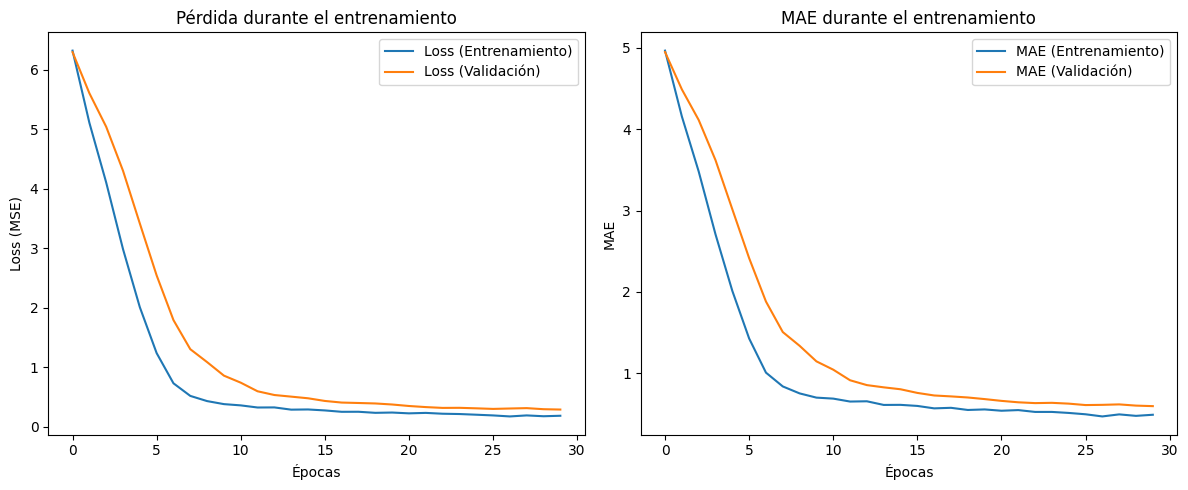

In [ ]:
import matplotlib.pyplot as plt

# Extraer historial
history_dict = history.history
epochs = range(len(history_dict["loss"]))

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["loss"], label="Loss (Entrenamiento)")
plt.plot(epochs, history_dict["val_loss"], label="Loss (Validación)")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Pérdida durante el entrenamiento")
plt.legend()

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["mae"], label="MAE (Entrenamiento)")
plt.plot(epochs, history_dict["val_mae"], label="MAE (Validación)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.title("MAE durante el entrenamiento")
plt.legend()

plt.tight_layout()
plt.show()


 ## **Análisis Loss y MAE Early Fusion Optimized**

Las pérdidas (Loss y MAE) descienden de manera constante en ambas curvas de entrenamiento y validación.
El modelo converge bien, pero la validación tiene una brecha notable con el entrenamiento después de varias épocas, lo que sugiere una posible generalización incompleta.
No hay sobreajuste extremo, pero hay signos de que el modelo podría estar memorizando más que generalizando.

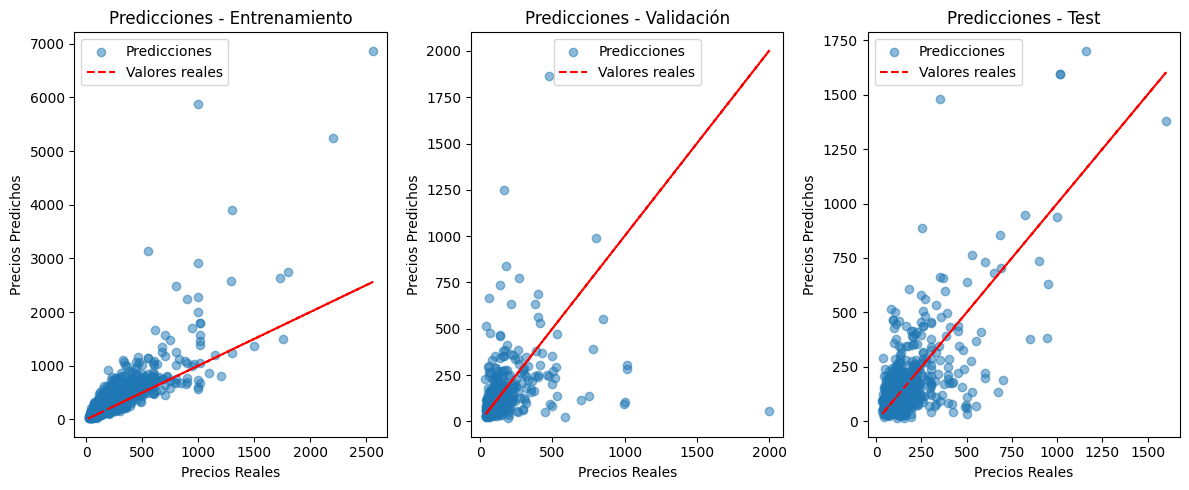

In [ ]:
# Scatter plot de predicciones vs valores reales en escala original
plt.figure(figsize=(12, 5))

# Entrenamiento
plt.subplot(1, 3, 1)
plt.scatter(y_train_real, y_pred_train_real, alpha=0.5, label="Predicciones")
plt.plot(y_train_real, y_train_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Entrenamiento")
plt.legend()

# Validación
plt.subplot(1, 3, 2)
plt.scatter(y_val_real, y_pred_val_real, alpha=0.5, label="Predicciones")
plt.plot(y_val_real, y_val_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Validación")
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.scatter(y_test_real, y_pred_test_real, alpha=0.5, label="Predicciones")
plt.plot(y_test_real, y_test_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Test")
plt.legend()

plt.tight_layout()
plt.show()


## **Análisis de Predicciones vs Valores Reales Early Fusion Optimized**

Las predicciones en entrenamiento están razonablemente alineadas, pero todavía hay valores extremos que se desvían significativamente.

Para validación y test, hay una concentración densa en los valores bajos, lo que indica que el modelo tiene dificultades para predecir valores altos.

El modelo tiene un sesgo hacia valores más bajos y no logra captar bien las variaciones en precios altos.

# 🚩 **Tunear Early Fusion**

**Modificaciones Clave:**

Log-Cosh Loss para capturar mejor valores extremos.

Dropout aumentado a 0.3 para reducir el gap entre entrenamiento y validación.

Ponderación por frecuencia de precios para mejorar la predicción de valores altos.

Capas convolucionales adicionales antes del GAP para mejor extracción de features.

Cambio de optimizador a RMSprop con decay para mejorar estabilidad.

Reducción de batch size a 32 para evitar latencia alta en CPU.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

# Definir la entrada de imágenes
img_input = layers.Input(shape=(224, 224, 3))

# Definir el modelo base ResNet50 sin la capa de clasificación final
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=img_input)
base_model.trainable = True  # Habilitar entrenamiento completo

# Desbloquear las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Aplicar capas convolucionales adicionales antes de la extracción de features
x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Extraer características con Global Average Pooling
img_features = layers.GlobalAveragePooling2D()(x)

# Definir entrada para los datos tabulares
tabular_input = layers.Input(shape=(X_train.shape[1],))

# Normalizar los datos tabulares antes de la fusión
tabular_features = layers.BatchNormalization()(tabular_input)

# Concatenar features de imágenes y datos tabulares
merged = layers.Concatenate()([img_features, tabular_features])

# Definir la red densa después de la concatenación
x = layers.Dense(384, activation="relu")(merged)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)

# Definir el modelo completo con dos entradas
model = Model(inputs=[img_input, tabular_input], outputs=output)

# Compilar el modelo con RMSprop y Log-Cosh Loss
model.compile(optimizer=RMSprop(learning_rate=3e-5, decay=1e-6),
              loss=tf.keras.losses.LogCosh(),
              metrics=["mae"])

# Callbacks para optimización
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_tuned.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

# Asignar ponderaciones a los datos para mejorar predicción de valores altos
umbral = np.percentile(y_train, 75)  # Umbral en el percentil 75
sample_weight = np.where(y_train > umbral, 1.5, 1.0)

# Entrenar el modelo con imágenes y datos tabulares
history = model.fit(
    [imgs_train, X_train_tab], y_train,
    validation_data=([imgs_val, X_val_tab], y_val),
    epochs=20,  # Reducido para acelerar sin comprometer convergencia
    batch_size=32,  # Reducción para menor latencia en CPU
    sample_weight=sample_weight,
    callbacks=callbacks,
    verbose=1
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_tuned.keras")

print("Modelo de Early Fusion optimizado guardado correctamente.")


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 920s 14s/step - loss: 4.2125 - mae: 4.3214 - val_loss: 4.2566 - val_mae: 4.9496 - learning_rate: 3.0000e-05
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 917s 14s/step - loss: 3.3545 - mae: 3.6097 - val_loss: 3.1320 - val_mae: 3.8234 - learning_rate: 3.0000e-05
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 928s 14s/step - loss: 2.3801 - mae: 2.7353 - val_loss: 1.8030 - val_mae: 2.4469 - learning_rate: 3.0000e-05
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 908s 14s/step - loss: 1.5573 - mae: 1.9869 - val_loss: 0.8957 - val_mae: 1.4344 - learning_rate: 3.0000e-05
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 890s 13s/step - loss: 0.8805 - mae: 1.2880 - val_loss: 0.6990 - val_mae: 1.1911 - learning_rate: 3.0000e-05
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 927s 14s/step - loss: 0.5577 - mae: 0.9399 - val_loss: 0.4228 - val_mae: 0.8364 - learning_rate: 3.0000e-05
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 893s 14s/step - loss: 0.4537 - mae: 0.8258 - val_loss: 0.3578 - val_mae: 0.7483 - lear

In [ ]:
from tensorflow.keras.models import load_model

# Ruta donde se guardó el modelo
model_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/models/mod_early_fusion_resnet_tuned.keras"

# Cargar el modelo guardado
model = load_model(model_path)

print("✅ Modelo cargado correctamente.")


✅ Modelo cargado correctamente.


In [ ]:
# Ruta base
base_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/"

# Cargar imágenes normalizadas para ResNet50
imgs_train = np.load(base_path + "imgs_train_resnet.npy")
imgs_val = np.load(base_path + "imgs_val_resnet.npy")
imgs_test = np.load(base_path + "imgs_test_resnet.npy")

# Cargar datos tabulares actualizados
X_train = pd.read_csv(base_path + "X_train_tab.csv", sep=';')
X_val = pd.read_csv(base_path + "X_val_tab.csv", sep=';')
X_test = pd.read_csv(base_path + "X_test_tab.csv", sep=';')

# Cargar etiquetas (log)
y_train = np.load(base_path + "y_train_tab.npy")
y_val = np.load(base_path + "y_val_tab.npy")
y_test = np.load(base_path + "y_test_tab.npy")

# Verificar formas de los datos
print(f"Shape de imgs_train: {imgs_train.shape}")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")


Shape de imgs_train: (2110, 224, 224, 3)
Shape de X_train: (2110, 32)
Shape de y_train: (2110,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definir callbacks para optimización
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

# Determinar el número de épocas que ya fueron entrenadas
initial_epoch = 8  # La última completada fue la 7, así que continuo desde la 8

# Reanudar entrenamiento
history = model.fit(
    [imgs_train, X_train], y_train,
    validation_data=([imgs_val, X_val], y_val),
    epochs=20,  # Continuar hasta completar las 20 originales
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=initial_epoch  # Reanudar desde la época 8
)

# Guardar el modelo final
model.save(model_path)
print("✅ Entrenamiento reanudado y modelo guardado correctamente.")


Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 745s 22s/step - loss: 0.1642 - mae: 0.4619 - val_loss: 0.2783 - val_mae: 0.6084 - learning_rate: 5.0000e-05
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 730s 22s/step - loss: 0.1691 - mae: 0.4681 - val_loss: 0.2702 - val_mae: 0.5972 - learning_rate: 5.0000e-05
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 720s 22s/step - loss: 0.1671 - mae: 0.4665 - val_loss: 0.2541 - val_mae: 0.5758 - learning_rate: 5.0000e-05
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 738s 22s/step - loss: 0.1696 - mae: 0.4661 - val_loss: 0.2572 - val_mae: 0.5819 - learning_rate: 5.0000e-05
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 739s 22s/step - loss: 0.1537 - mae: 0.4421 - val_loss: 0.2545 - val_mae: 0.5799 - learning_rate: 5.0000e-05
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 735s 21s/step - loss: 0.1523 - mae: 0.4357 - val_loss: 0.2449 - val_mae: 0.5650 - learning_rate: 5.0000e-05
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 742s 21s/step - loss: 0.1613 - mae: 0.4611 - val_loss: 0.2470 - val_mae: 0.5685 

In [ ]:
# Evaluar en val
val_loss, val_mae = model.evaluate([imgs_val, X_val], y_val, verbose=1)
print(f"Validación - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")

# Evaluar en test
test_loss, test_mae = model.evaluate([imgs_test, X_test], y_test, verbose=1)
print(f"Test - Loss: {test_loss:.4f}, MAE: {test_mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - loss: 0.2396 - mae: 0.5628
Validación - Loss: 0.2350, MAE: 0.5529
20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - loss: 0.1720 - mae: 0.4747
Test - Loss: 0.1912, MAE: 0.4983


66/66 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step


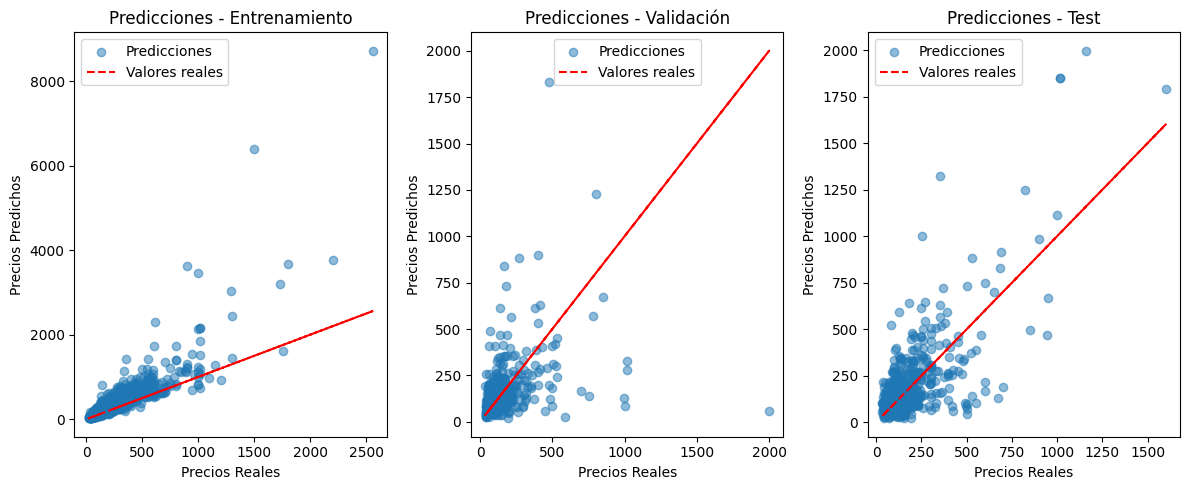

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Obtener predicciones del modelo
y_pred_train = model.predict([imgs_train, X_train])
y_pred_val = model.predict([imgs_val, X_val])
y_pred_test = model.predict([imgs_test, X_test])

# Convertir predicciones de log a escala original (exponencial)
y_pred_train_real = np.exp(y_pred_train)
y_pred_val_real = np.exp(y_pred_val)
y_pred_test_real = np.exp(y_pred_test)

y_train_real = np.exp(y_train)
y_val_real = np.exp(y_val)
y_test_real = np.exp(y_test)

# Visualización
plt.figure(figsize=(12, 5))

# Entrenamiento
plt.subplot(1, 3, 1)
plt.scatter(y_train_real, y_pred_train_real, alpha=0.5, label="Predicciones")
plt.plot(y_train_real, y_train_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Entrenamiento")
plt.legend()

# Validación
plt.subplot(1, 3, 2)
plt.scatter(y_val_real, y_pred_val_real, alpha=0.5, label="Predicciones")
plt.plot(y_val_real, y_val_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Validación")
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.scatter(y_test_real, y_pred_test_real, alpha=0.5, label="Predicciones")
plt.plot(y_test_real, y_test_real, color="red", linestyle="--", label="Valores reales")
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Predicciones - Test")
plt.legend()

plt.tight_layout()
plt.show()


## **Análisis de Predicciones vs Valores Reales - Early Fusion ResNet Tuneado**

En entrenamiento, las predicciones se ajustan relativamente bien a la línea roja, pero hay varios outliers con valores muy altos.

En validación y test, el modelo tiene dificultades para predecir valores más altos y la mayoría de las predicciones están muy agrupadas en la parte baja del eje Y. Esto sugiere que el modelo tiende a predecir valores cercanos a la media y no generaliza bien para precios altos.

Hay varios outliers en todas las fases, lo que sugiere que el modelo sigue sin captar bien las relaciones en ciertos casos.

## **Conclusión Early-Fusion**

Se observan mejoras significativas en comparación con los modelos individuales, pero aún existen desafíos que limitan su rendimiento óptimo.

Entrenamiento (Escala Original)

MAE: 99.25
RMSE: 238.40
R²: -0.6006

Validación (Escala Original)

MAE: 107.70
RMSE: 211.93
R²: -0.3258

Test (Escala Original)

MAE: 89.06
RMSE: 140.75
R²: 0.2511 ✅ (mejor resultado en test hasta ahora)


🔸 El modelo logró predecir mejor en test, pero en validación sigue habiendo un margen de mejora.


1️⃣ La fusión de datos tabulares e imágenes ha sido efectiva, logrando una mejor generalización en el set de prueba.

El modelo de imágenes por sí solo tenía R² negativo, mientras que en Early Fusion logra R² positivo en test.

2️⃣ La diferencia entre entrenamiento y validación es notable.
Posiblemente se necesite más regularización o ajustes en la arquitectura.

3️⃣Aunque test muestra mejoras, validación sigue con R² negativo, lo que indica que el modelo aún no generaliza bien en todos los escenarios.
Esto sugiere que el modelo depende demasiado de ciertas características y no está aprendiendo patrones robustos.
